### 1. Pobranie zbioru cifar i wyświetlenie kilku obrazów

100.0%


Extracting ./data\cifar-10-python.tar.gz to ./data


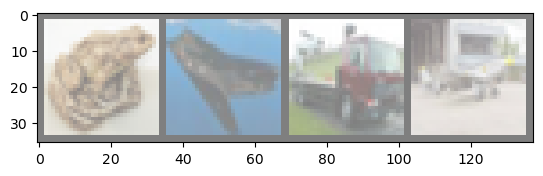

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

# Define a transform to normalize the data and convert it to a tensor
transform = transforms.Compose([transforms.ToTensor()])

# Download and load the CIFAR-10 training dataset
trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)

# Create a DataLoader to iterate over the dataset
trainloader = torch.utils.data.DataLoader(trainset, batch_size=4, shuffle=True, num_workers=2)

# Function to display images
def imshow(img):
    img = img / 2 + 0.5  # unnormalize the image
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# Get a batch of training images
dataiter = iter(trainloader)
images, labels = next(dataiter)

# Display the images
imshow(torchvision.utils.make_grid(images))
